In [70]:
import json 

train = json.load(open("newest_EMOTIC_train_x1y1x2y2.json"))
train

{'images': [{'database': 'EMOTIC',
   'file_name': 'COCO_val2014_000000562243.jpg',
   'folder': 'mscoco/images',
   'name': 'mscoco',
   'height': 640,
   'width': 640,
   'id': 0,
   'coco_ids': {'image_id': 562243, 'annotations_id': 448867}},
  {'database': 'EMOTIC',
   'file_name': 'COCO_train2014_000000288841.jpg',
   'folder': 'mscoco/images',
   'name': 'mscoco',
   'height': 480,
   'width': 640,
   'id': 1,
   'coco_ids': {'image_id': 288841, 'annotations_id': 1750456}},
  {'database': 'EMOTIC',
   'file_name': 'COCO_val2014_000000558171.jpg',
   'folder': 'mscoco/images',
   'name': 'mscoco',
   'height': 480,
   'width': 640,
   'id': 2,
   'coco_ids': {'image_id': 558171, 'annotations_id': 467799}},
  {'database': 'EMOTIC',
   'file_name': 'COCO_train2014_000000369575.jpg',
   'folder': 'mscoco/images',
   'name': 'mscoco',
   'height': 640,
   'width': 480,
   'id': 3,
   'coco_ids': {'image_id': 369575, 'annotations_id': 192459}},
  {'database': 'EMOTIC',
   'file_name': 

In [71]:
from collections import Counter

image_ids = [item["image_id"] for item in train["annotations"]]
counter = Counter(image_ids)
most_common_image_ids = counter.most_common(10)

most_common_image_ids


[(11095, 22),
 (4377, 18),
 (5182, 18),
 (6128, 17),
 (11804, 17),
 (9227, 16),
 (12131, 16),
 (2483, 15),
 (12231, 15),
 (6307, 14)]

In [72]:
from collections import Counter

image_ids = [item["id"] for item in train["images"] if item["name"] == "framesdb"]
counter = Counter(image_ids)
most_common_image_id, occurrence = counter.most_common(1)[0]

most_common_image_id, occurrence


(13, 1)

In [76]:

img = [item for item in train["images"] if item["id"] == 11804][0]
img



{'database': 'EMOTIC',
 'file_name': 'frame_5j8kf9privvsjp3u.jpg',
 'folder': 'framesdb/images',
 'name': 'framesdb',
 'height': 552,
 'width': 980,
 'id': 11804,
 'coco_ids': []}

In [77]:
bboxes = [item["bbox"] for item in train["annotations"] if item["image_id"] == 11804]
bboxes

[[275, 12, 403, 353],
 [267, 38, 401, 351],
 [836, 222, 954, 551],
 [837, 209, 952, 545],
 [611, 80, 743, 506],
 [610, 133, 733, 474],
 [209, 106, 279, 333],
 [205, 109, 278, 325],
 [3, 88, 60, 330],
 [0, 86, 60, 315],
 [424, 55, 542, 429],
 [411, 69, 547, 399],
 [76, 72, 159, 320],
 [68, 91, 141, 318],
 [380, 50, 443, 374],
 [376, 85, 444, 329],
 [740, 150, 840, 527]]

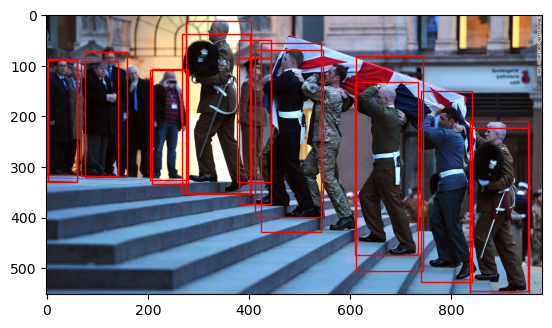

In [78]:
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np
from PIL import Image

url = "EMOTIC (1)\EMOTIC\PAMI\emotic\/framesdb\images/frame_5j8kf9privvsjp3u.jpg"
url = url.replace("\\", "/")

image = Image.open(url)
image_np = np.array(image)

fig, ax = plt.subplots(1)
ax.imshow(image_np)

# Color map for different classes
color_map = plt.get_cmap('tab20b')

for box in bboxes:
    xmin, ymin, xmax, ymax = box
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [67]:
def iou(box1, box2):
    """Calculates Intersection Over Union (IOU) between two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    interArea = max(0, min(x2, x2g) - max(x1, x1g)) * max(0, min(y2, y2g) - max(y1, y1g))
    boxAArea = (x2 - x1) * (y2 - y1)
    boxBArea = (x2g - x1g) * (y2g - y1g)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [68]:

iou_values = []
for i in range(len(bboxes)):
    for j in range(i+1, len(bboxes)):
        iou_value = iou(bboxes[i], bboxes[j])
        iou_values.append(iou_value)

iou_values
len(iou_values)

276

In [69]:

from statistics import mean, median
non_zero_values = [value for value in iou_values if value != 0]
non_zero_values
len(non_zero_values), mean(non_zero_values), median(non_zero_values)

(47, 0.2342550558730983, 0.12949785742767767)

In [11]:
l = [1,3,4, 6]
u = [2, 5, 7, 8]

In [12]:
l + u

[1, 3, 4, 6, 2, 5, 7, 8]

# image tt seule

In [13]:
bbx_base = bboxes

In [26]:
len(bbx_base)

14

In [14]:
import torch
import numpy as np
import torchvision.transforms as T 
from PIL import Image
from torchvision.transforms import functional as F
import os
import json
from transformers import AutoImageProcessor, DetrForObjectDetection
import requests 

In [19]:
MAX_ANNotATIONS = 30

def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)
    image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
    return model, image_processor, device

def model_results(img, model, image_processor, device):
    inputs = image_processor(images=img, return_tensors="pt").to(device)
    outputs = model(**inputs)
    results = image_processor.post_process_object_detection(outputs, threshold=0.95, target_sizes=torch.tensor([img.size[::-1]]).to(device))[0]

    person_scores = []
    person_labels = []
    person_boxes = []

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if model.config.id2label[label.item()] == 'person':
            person_labels.append(label)
            person_boxes.append(box)
            person_scores.append(score.item())  

    # Sorting the results by score
    sorted_indices = np.argsort(person_scores)[::-1]  

    sorted_person_labels = [person_labels[i] for i in sorted_indices]
    sorted_person_boxes = [person_boxes[i] for i in sorted_indices]
    sorted_person_scores = [person_scores[i] for i in sorted_indices]


    sorted_results = {
        "scores": sorted_person_scores,
        "labels": sorted_person_labels,
        "boxes": sorted_person_boxes
    }

    bboxes = [[int(x) for x in bbox] for bbox in sorted_results["boxes"]]
    
    return bboxes[:MAX_ANNotATIONS]



In [20]:
url = "EMOTIC (1)\EMOTIC\PAMI\emotic\/emodb_small\images/4m7t3bsqtw1upazkri.jpg"
url = url.replace("\\", "/")
image = Image.open(url)
model, image_processor, device = load_model()
new_bbx = model_results(image, model, image_processor, device)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model conf

In [21]:
new_bbx

[[675, 430, 817, 920],
 [999, 908, 1464, 1263],
 [1659, 601, 1895, 1072],
 [1009, 764, 1241, 1063],
 [1211, 729, 1331, 922],
 [1299, 644, 1408, 830],
 [1458, 797, 1601, 1073],
 [1592, 627, 1747, 1019],
 [1731, 468, 1807, 623],
 [1879, 388, 1989, 565]]

In [27]:
len(new_bbx)

10

In [22]:

def iou(box1, box2):
    """Calculates Intersection Over Union (IOU) between two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    interArea = max(0, min(x2, x2g) - max(x1, x1g)) * max(0, min(y2, y2g) - max(y1, y1g))
    boxAArea = (x2 - x1) * (y2 - y1)
    boxBArea = (x2g - x1g) * (y2g - y1g)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def remove_duplicates(bboxes):
    """Remove duplicate bounding boxes."""
    unique_bboxes = []
    [unique_bboxes.append(x) for x in bboxes if x not in unique_bboxes]
    return unique_bboxes

def get_iou_annotations(anno_bboxes, model_bboxes):
    """Adjusts annotation bounding boxes based on IOU with model predictions."""
    keep_flags = [True] * len(model_bboxes)
    for i, model_bbox in enumerate(model_bboxes):
        for anno_bbox in anno_bboxes:
            if iou(anno_bbox, model_bbox) >= 0.5:
                keep_flags[i] = False
                break 

    adjusted_model_bboxes = [bbox for bbox, keep in zip(model_bboxes, keep_flags) if keep]

    new_annots = remove_duplicates(anno_bboxes + adjusted_model_bboxes)

    return new_annots

In [42]:
new_bbx_iou = get_iou_annotations(new_bbx, new_bbx)
len(new_bbx_iou)

10

In [23]:
final_ann = get_iou_annotations(bbx_base, new_bbx)

In [24]:
final_ann

[[1011, 770, 1197, 1080],
 [1338, 826, 1474, 1091],
 [1762, 607, 1882, 1077],
 [986, 911, 1461, 1253],
 [1736, 468, 1802, 594],
 [1440, 790, 1600, 1069],
 [1625, 628, 1749, 1040],
 [687, 434, 812, 915],
 [1836, 491, 1938, 927],
 [1874, 387, 2000, 512],
 [1273, 664, 1375, 816],
 [1208, 727, 1328, 916],
 [1461, 680, 1541, 787],
 [1246, 688, 1321, 808],
 [1659, 601, 1895, 1072],
 [1299, 644, 1408, 830]]

In [28]:
len(final_ann)

16

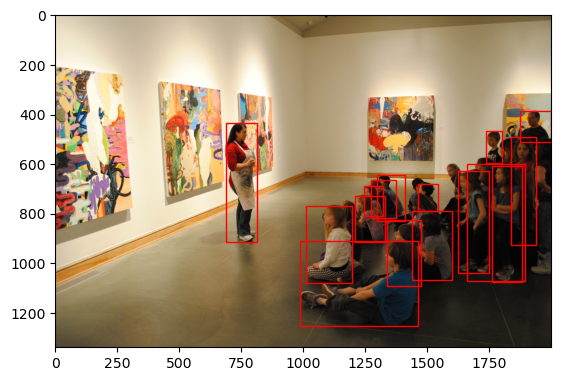

In [25]:
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np
from PIL import Image

url = "EMOTIC (1)\EMOTIC\PAMI\emotic\/emodb_small\images/4m7t3bsqtw1upazkri.jpg"
url = url.replace("\\", "/")

image = Image.open(url)
image_np = np.array(image)

fig, ax = plt.subplots(1)
ax.imshow(image_np)

# Color map for different classes
color_map = plt.get_cmap('tab20b')

for box in final_ann:
    xmin, ymin, xmax, ymax = box
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()